# Multi-label fine-tuned ClinicalBert, using ChatGPT Summarization

#### Necessary Imports
Please use:  
pip install pandas tensorflow transformers numpy nltk matplotlib openai  
If you do not have any of the packages  
Please use Python 3.10.13.  
An easy way to achieve all of this is with anaconda - create an environment with python 3.10.13 and all of the necessary packages.  
```conda create -n env-name python=3.10 tensorflow transformers numpy pandas nltk matplotlib openai```  
Make sure env-name is selected as the environment when running the notebook.

In [1]:
import model_helpers
import utils
import pickle
LABELS = ["ABDOMINAL",
        "ADVANCED-CAD",
        "ALCOHOL-ABUSE",
        "ASP-FOR-MI",
        "CREATININE",
        "DIETSUPP-2MOS",
        "DRUG-ABUSE",
        "ENGLISH",
        "HBA1C",
        "KETO-1YR",
        "MAJOR-DIABETES",
        "MAKES-DECISIONS",
        "MI-6MOS"]


c:\Users\nlabu\anaconda3\envs\tfenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\nlabu\anaconda3\envs\tfenv\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


### Retrieving Data

In [2]:
# Both will be dataframes with a 'notes' column and a column for each label
train_data = utils.get_note_data(LABELS, folder_name='train')
test_data = utils.get_note_data(LABELS, folder_name='test')

## Quick Data Exploration

Remember how the data were too large to pass into BERT without significant truncation? Well, we can have ChatGPT extract the important data from the notes, then have ClinicalBERT learn on this data extraction.  

Here is a quick reminder of the size of the data:

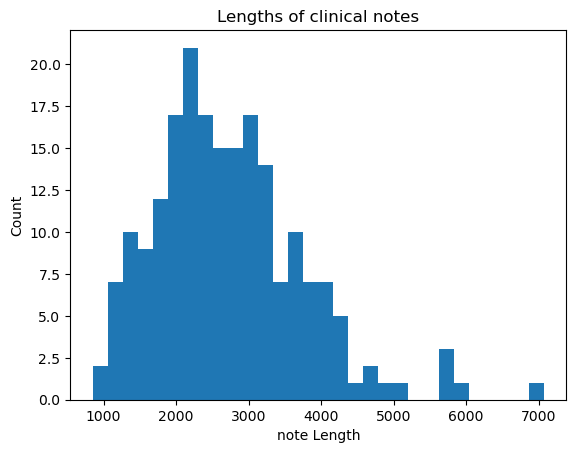

In [3]:
utils.display_histogram(train_data)

Again, these are much too long to pass into BERT, which has a max_token count of 512. However, ChatGPT's max_token count is 4096. Thus, after removing stop words, almost every note fits within this limit.

### Remaking the Data

Code put in markdown so that we don't accidentally run it. If you wish to run it, please ensure you have your own openAI key, then change it back to code.

### If you do not have an OpenAI API Key:
Please follow steps one (if needed) and two (probably needed) of the following guide: https://platform.openai.com/docs/quickstart?context=python  
Keep in mind that the code __*will charge the account*__ that the key is associated with.

```python
import chatGPT_helpers
new_train_notes = chatGPT_helpers.summarize_and_save_notes(list(train_data['notes']), name='train')
new_test_notes = chatGPT_helpers.summarize_and_save_notes(list(test_data['notes']), name='test')
```

In [4]:
with open('summarized_notes_train.pkl', 'rb') as f:
    # Load the object from the file
    new_train_notes = pickle.load(f)
train_data['notes'] = new_train_notes

with open('summarized_notes_test.pkl', 'rb') as f:
    # Load the object from the file
    new_test_notes = pickle.load(f)
test_data['notes'] = new_test_notes

### Making the models (same as before, different data now)

In [5]:
model, _ = model_helpers.create_multi_label(train_data, test_data=test_data, num_epochs=5)

c:\Users\nlabu\anaconda3\envs\tfenv\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
7/7 [==============================] - 322s 47s/step - loss: 2.1760 - accuracy: 0.0792 - val_loss: 1.3731 - val_accuracy: 0.0349 - lr: 0.0010
Epoch 2/5
7/7 [==============================] - 344s 49s/step - loss: 1.7652 - accuracy: 0.0297 - val_loss: 1.3145 - val_accuracy: 0.0233 - lr: 0.0010
Epoch 3/5
7/7 [==============================] - 360s 53s/step - loss: 1.7748 - accuracy: 0.0297 - val_loss: 1.3772 - val_accuracy: 0.0233 - lr: 0.0010
Epoch 4/5
7/7 [==============================] - 306s 43s/step - loss: 1.7720 - accuracy: 0.0149 - val_loss: 1.3448 - val_accuracy: 0.0233 - lr: 0.0010
Epoch 5/5
7/7 [==============================] - 349s 51s/step - loss: 1.7972 - accuracy: 0.0198 - val_loss: 1.3194 - val_accuracy: 0.0233 - lr: 0.0010


### Hyperparameter Tuning

__The history was saved so that the hyper-parameter tuning need not be done again.__

This was performed for this model as well, with similar results for epoch choice.

In [6]:
# Load history from the pickle file
with open(f'summarize_history.pkl', 'rb') as file:
    history1 = pickle.load(file)


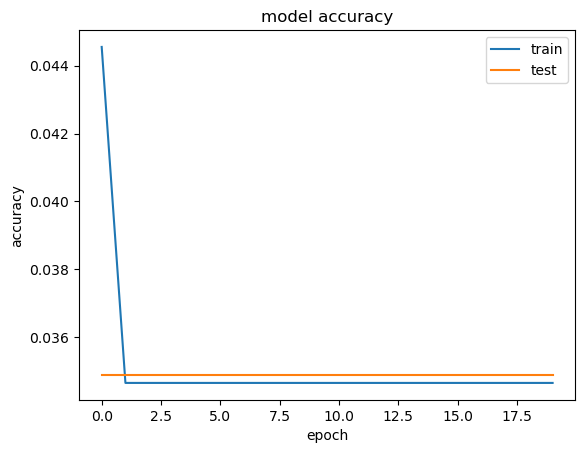

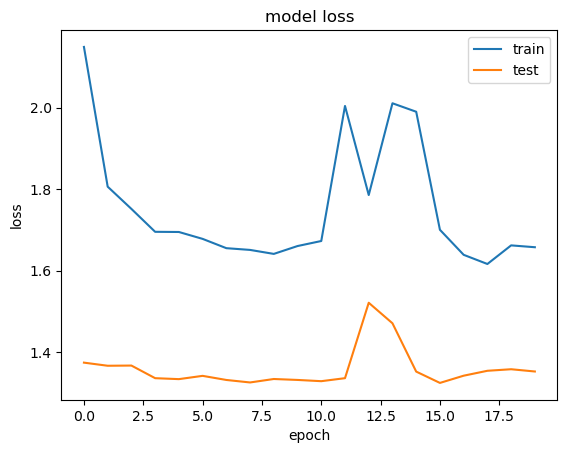

In [7]:
# TODO: Create a graph for the history of the multi-label model
utils.make_history_graph(history1)

No significant improvement seen after epoch 5.

### Evaluating the Model

In [8]:
predictions = model_helpers.get_predictions(model, test_data)
label_to_predictions = {}
# Simple column extraction to format correclty for helper function in next cell
for label, column in zip(LABELS, range(predictions.shape[1])):
    column_values = predictions[:, column]
    label_to_predictions[label] = column_values

3/3 [==============================] - 96s 28s/step


Save predictions and load predictions here if wanted.

In [9]:
utils.save_preds(label_to_predictions, "summary_models_predicitions")

In [10]:
label_to_predictions = utils.read_preds("summary_models_predicitions")

c:\Users\nlabu\OneDrive - Northeastern University\Documents\GitHub\Final-Project\utils.py:80: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label_to_predictions[row[0]] = list(row[1:])


### Performance:

In [11]:

label_to_micro_f1, overall_f1 = utils.get_f1_scores_for_labels(LABELS, test_data, label_to_predictions)
print('overall-f1:', overall_f1)

Raw f1 for ABDOMINAL 0.1744186046511628
Raw f1 for ADVANCED-CAD 0.2616279069767442
Raw f1 for ALCOHOL-ABUSE 0.49112426035502965
Raw f1 for ASP-FOR-MI 0.3953488372093023
Raw f1 for CREATININE 0.13953488372093023
Raw f1 for DIETSUPP-2MOS 0.2558139534883721
Raw f1 for DRUG-ABUSE 0.49112426035502965
Raw f1 for ENGLISH 0.42441860465116277
Raw f1 for HBA1C 0.20348837209302328
Raw f1 for KETO-1YR 0.5
Raw f1 for MAJOR-DIABETES 0.3333333333333333
Raw f1 for MAKES-DECISIONS 0.48255813953488375
Raw f1 for MI-6MOS 0.475609756097561
overall-f1: 0.35603083942050273
